In [7]:
def normalizeData(n, d, X, y):
    for i in range(n):
        Xi_max = max(X[i])
        Xi_min = min(X[i])
        X_diff = Xi_max - Xi_min
        for j in range(d):
            X[i][j] = (X[i][j] - Xi_min)/X_diff

    y_max = max(y)
    y_min = min(y)
    y_diff = y_max - y_min
    y = (y-y_min)/y_diff
    return X, y


def plotter(X, y, n, d, k, epsilon, jump):
    
    X = X[:n, :d]
    y = y[:n]
    
    elems = math.floor((d/2)*(d+1))
    split_val = math.floor(n/k)
    m = math.floor((n-split_val)/jump)
    
    X = np.append(arr=np.ones((n,1)), values=X, axis=1)

    X,y = normalizeData(n,d,X,y)

    RMSE = np.zeros((k, m))
    priv_RMSE = np.zeros((k, m))
    X_val = np.zeros((m))

    for i in range(1):
    
        X_test = X[i*split_val:(i+1)*split_val, :]
        y_test = y[i*split_val:(i+1)*split_val]
    
        X_without_XTest = X[:i*split_val, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(i+1)*split_val:, :], axis=0)
    
        y_without_yTest = y[:i*split_val]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(i+1)*split_val:], axis=0)
    
        for j in range(m):
            X_val[j] = math.floor((j+1)*jump)
            train_size = math.floor((j+1)*jump)
            X_train = X_without_XTest[:train_size, :]
            y_train = y_without_yTest[:train_size]
        
            xT = X_train.transpose()
            xTx = np.matmul(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.matmul(xT, y_train)
            w = np.matmul(xTx_pinv, xTy)
        
            priv_RMSE_per_lpl = np.zeros((10))
        
            for l in range(10):
                b1 = 1/(epsilon*elems)
                b2 = d/epsilon
            
                mirror_half = math.floor(((d+2)/2)*(d+1))
                u_mirr = np.random.laplace(loc=0.0, scale=b1, size = mirror_half)
                pos = 0
                u = np.ones((d+1, d+1))
                for r in range(d+1):
                    for c in range(r, d+1):
                        u[c][r] = u_mirr[pos]
                        u[r][c] = u[c][r]
                        pos = pos+1
                v = np.random.laplace(loc=0.0, scale=b2, size = d+1)
            
                sTs = xTx + u
                sTt = xTy + v
                sTs_pinv = np.linalg.pinv(sTs)
                wi = np.matmul(sTs_pinv, sTt)
                T = np.matmul(X_test, wi)
                priv_RMSE_per_lpl[l] = np.mean(abs(T-y_test)**2)**0.5

            priv_RMSE[i][j] = np.mean(priv_RMSE_per_lpl)
            y_pred = np.matmul(X_test, w)
            RMSE[i][j] = np.mean(abs(y_pred-y_test)**2)**0.5

    total_RMSE = sum(RMSE)/k
    priv_total_RMSE = sum(priv_RMSE)/k

    RMSE_SD = np.zeros((m))
    priv_RMSE_SD = np.zeros((m))
    for i in range(m):
        RMSE_SD[i] = RMSE[:, i:i+1].std()
        priv_RMSE_SD[i] = priv_RMSE[:, i:i+1].std()

    ans = np.zeros((5,m))
    ans[0] = X_val
    ans[1] = priv_total_RMSE
    ans[2] = priv_RMSE_SD
    ans[3] = total_RMSE
    ans[4] = RMSE_SD

    return ans

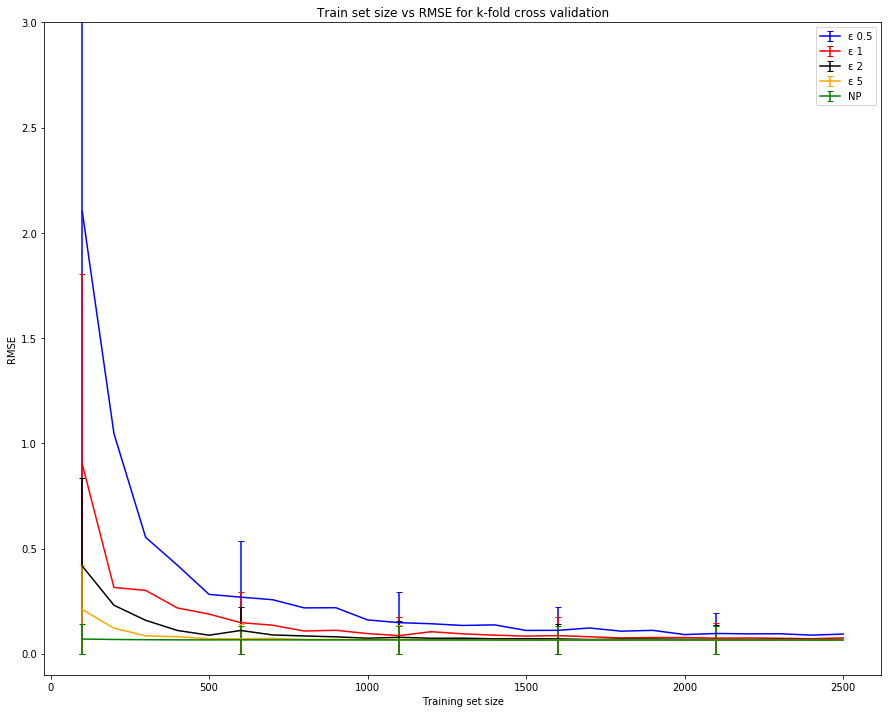

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab

n = 5000
d = 10
k = 2
eps = [0.5, 1, 2, 5]
jump = 100

X, y = make_regression(n_samples = n, n_features = d, noise=10)

colors = ["blue", "red", "black", "orange", "green"]

for eps_idx in range(len(eps)):
    epsilon = eps[eps_idx]
    ans = plotter(X, y, n, d, k, epsilon, jump)
    
    plt.errorbar(ans[0], ans[1], yerr=ans[2], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon), errorevery=5)
#     plt.scatter(ans[0], ans[1], color=colors[eps_idx], s=10)
 
plt.rcParams['figure.figsize'] = (5, 3)
plt.errorbar(ans[0], ans[3], yerr=ans[4], color=colors[4], ecolor=colors[4], capsize=3, label="NP", errorevery = 5)
# plt.scatter(ans[0], ans[3], color=colors[4], s=10)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.ylim(-0.1,3)
plt.title("Train set size vs RMSE for k-fold cross validation")
plt.show()





[[-0.5236448   0.43953121 -1.11316546 ... -0.49522339 -0.43800795
   1.11947997]
 [ 0.08331094  0.09815733  1.981009   ... -0.16913866 -0.63371136
   2.34857324]
 [-0.06237669 -0.01083724 -2.38071436 ... -0.03386824 -1.68008314
  -1.82118902]
 ...
 [-0.44399401 -0.15455442  0.51720894 ...  0.41163708  1.35651911
  -1.16074408]
 [-0.22381702 -0.79398947 -1.72970212 ...  0.49461356 -1.33632583
  -1.00590849]
 [-1.50268682 -0.11606229 -0.61727119 ...  0.64419805 -0.15550997
   0.68737875]]


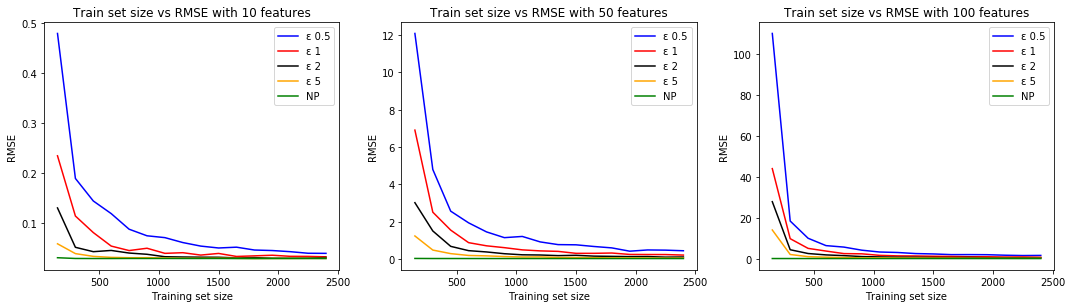

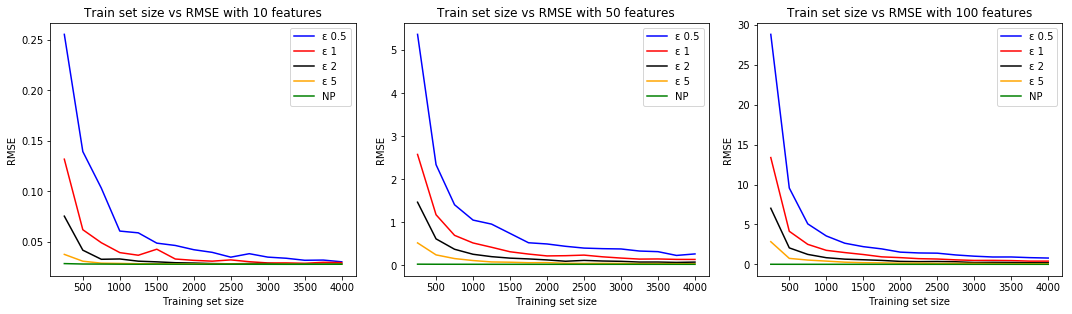

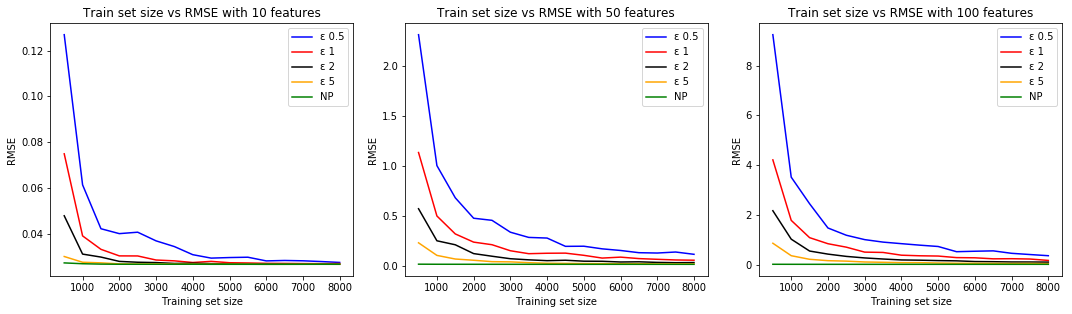

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab

entries = [3000, 5000, 10000]
features = [10, 50, 100]
k = 5
eps = [0.5, 1, 2, 5]
plotnum = 1

X, y = make_regression(n_samples = entries[len(entries)-1], n_features = features[len(features)-1], noise=20)

colors = ["blue", "red", "black", "orange", "green"]

for i in range(len(entries)):
    n = entries[i]
    jump = math.floor(n/20)
    for j in range(len(features)):
        d = features[j]
        plt.rcParams['figure.figsize'] = (15, 12)
        plt.subplot(len(entries),len(features),plotnum)
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = plotter(X, y, n, d, k, epsilon, jump)
    
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
#             plt.scatter(ans[0], ans[1], color=colors[eps_idx], s=10)
 
        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")
#         plt.scatter(ans[0], ans[3], color=colors[4], s=10)
        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with " + str(d) + " features")
        plotnum = plotnum+1
    plt.tight_layout()
    plt.show()


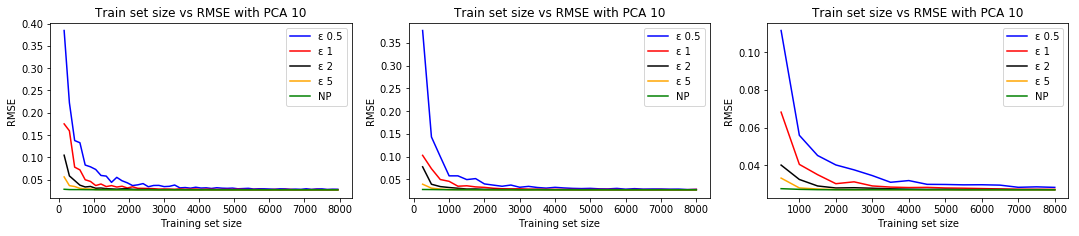

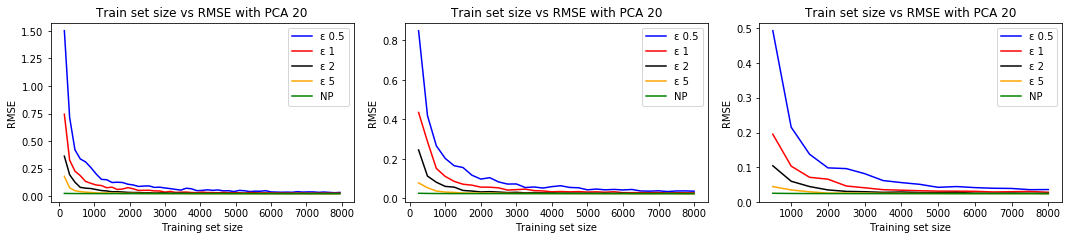

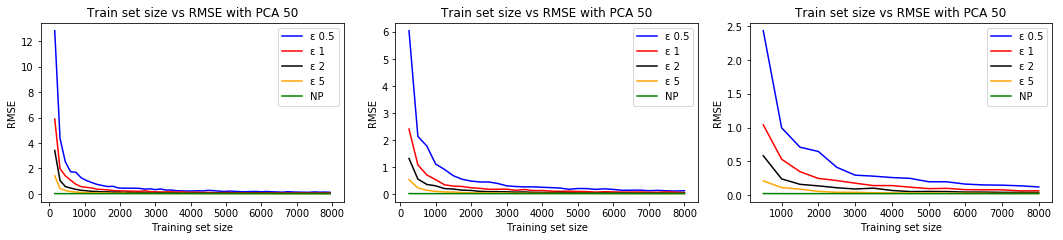

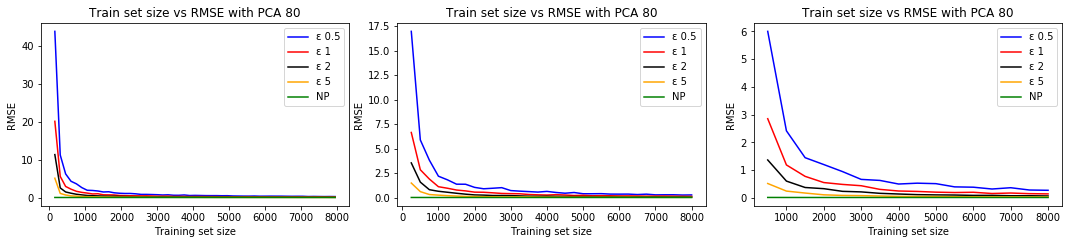

In [34]:
from sklearn.decomposition import PCA

def getPCA(d, X):
    pca = PCA(n_components=d)
    x_pca = pca.fit_transform(X)
    return x_pca


reduced_d = [10, 20, 50, 80]
plotnum = 1
for i in range(len(reduced_d)):
    d = reduced_d[i]   
    x_pca = getPCA(di, X)
    for j in range(len(entries)):
        entry = entries[j]
        jump = math.floor(entry/20)
        plt.rcParams['figure.figsize'] = (15, 12)
        plt.subplot(len(reduced_d),len(entries),plotnum)
        
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = plotter(X, y, n, d, k, epsilon, jump)
    
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
 
        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")

        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with PCA " + str(d))
        plotnum = plotnum+1
        
    plt.tight_layout()
    plt.show()


# From BTP

In [105]:
import numpy as np
import random
from random import shuffle
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.cm as cm
import statistics
import csv
import time


### Function Definitions

In [229]:
def generateSyntheticData(n, d):
    
    mean=[[0],[100],[-100],[200],[-200],[300],[-300]]    
    variance = np.eye(d)
    inputData = []
    outputData = []
    w = np.random.multivariate_normal([0]*d,np.eye(d))
    m = 1
    iteration = m
    while (iteration > 0):
        for i in range(int((iteration-1)*n/m), int(iteration*n/m)):
            x = np.random.multivariate_normal(mean[m-iteration]*d,100*variance)
            e = np.random.multivariate_normal(mean[m-iteration],np.eye(1))
            y = np.dot(w,x)+e
            inputData.append(x)
            outputData.append(y)
        iteration = iteration-1
    return inputData, outputData, w


def normalizeData(X, y, n, d): 
    for i in range(n):
        x_max = max(X[i])
        x_min = min(X[i])
        for j in range(d):
            X[i][j] = (X[i][j]-x_min)/(x_max-x_min)
    
    y_max = max(y)
    y_min = min(y)
    for i in range(n):
        y[i] = (y[i]-y_min)/(y_max-y_min)
    return X, y


def laplaceFunction(xTx, xTy, e):
    d = xTx.shape[0]
    e1 = e
    e = e1*d*(d+1)/2
    z = np.zeros((d,d))
    for i in range(d):
        for j in range(i,d):
            z[i][j] = np.random.laplace(scale = 1/e)
    for i in range(d-1,-1,-1):
        for j in range(i-1,-1,-1):
            z[i][j] = z[j][i]
    v = np.random.laplace(size=(d,1),scale = 1/e1)
    return xTx+z,xTy+v

In [241]:
def PrivacyAwareRegressionNonPrivate(n, training_size ,d, X_norm, y_norm, jump):
    rms_error = []
    x_axis_index = []
    
    for m in range(100, training_size, jump):
        x_axis_index.append(m)
        rms_error.append([])
    
        X_train = np.asarray(X_norm[:m])
        y_train = np.asarray(y_norm[:m])
    
        X_test = np.asarray(X_norm[training_size:])
        y_test = np.asarray(y_norm[training_size:])
     
        X = X_train
        y = y_train
        xTx = np.dot(X.transpose(),X)
        xTy = np.dot(X.transpose(),y)
        
        w = np.dot(np.linalg.pinv(xTx), xTy)
        y_pred = np.dot(X_test, w)

        rms_mean = (np.mean((y_test-y_pred)**2))**0.5
        rms_error[x_axis_index.index(m)].append(rms_mean)
            
    return x_axis_index, rms_error

def PrivacyAwareRegression(n, training_size ,d, X_norm, y_norm, ep, jump):
    rms_error = []
    x_axis_index = []
    
    for m in range(100, training_size, jump):
        x_axis_index.append(m)
        rms_error.append([])
        
        X_train = np.asarray(X_norm[:m])
        y_train = np.asarray(y_norm[:m])
    
        X_test = np.asarray(X_norm[training_size:])
        y_test = np.asarray(y_norm[training_size:])
     
        X = X_train
        y = y_train
        xTx = np.dot(X.transpose(),X)
        xTy = np.dot(X.transpose(),y)
        
        w = np.dot(np.linalg.pinv(xTx), xTy)
        
        n_samplings  = 10
        error = []
        
        for i in range(n_samplings):
            sTs, sTt = laplaceFunction(xTx, xTy, ep)
            w_priv = np.matmul(np.linalg.pinv(sTs),sTt)        
            T = np.dot(X_test, w_priv)
            error.append(np.sqrt(np.sum(np.square(y_test-T))/d))
            
        rms_mean = sum(error)/len(error)
        rms_error[x_axis_index.index(m)].append(rms_mean)
            
    return x_axis_index, rms_error

# Get Synthetic data and find errors

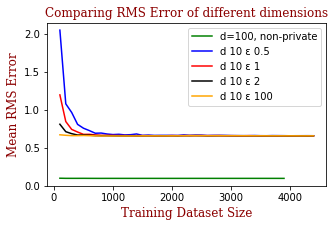

In [242]:
n = 5000
test_size = math.floor(n/5)
jump = 100
d = 10

X, y, w = generateSyntheticData(n,d)

X_norm, y_norm = normalizeData(X, y, n, d)

eps = [0.5, 1, 2, 100]
colors = ["blue", "red", "black", "orange", "green"]

x_axis, RMSE = PrivacyAwareRegressionNonPrivate(n, n-test_size, d, X_norm, y_norm, jump)
plt.plot(x_axis, RMSE[:len(x_axis)], color = 'green', label = 'd=100, non-private')

for i in range(len(eps)):
    epsilon = eps[i]
    x_axis, RMSE = PrivacyAwareRegression(n, train_size, d, X_norm, y_norm, epsilon, jump)
    plt.plot(x_axis, RMSE[:len(x_axis)], color = colors[i], label = 'd ' + str(d) + ' ε ' + str(epsilon))

plt.xlabel("Training Dataset Size", fontdict=font)
plt.ylabel("Mean RMS Error", fontdict=font)
plt.title("Comparing RMS Error of different dimensions", fontdict=font)
plt.legend(loc='upper right')
plt.show()

# Implement PCA